In [3]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [5]:
df = pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

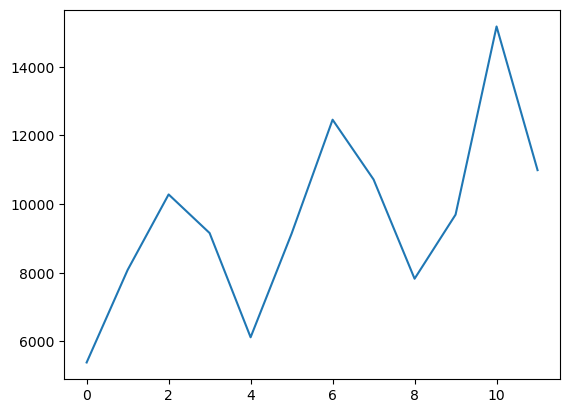

In [6]:
plt.plot(df["Sales"])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

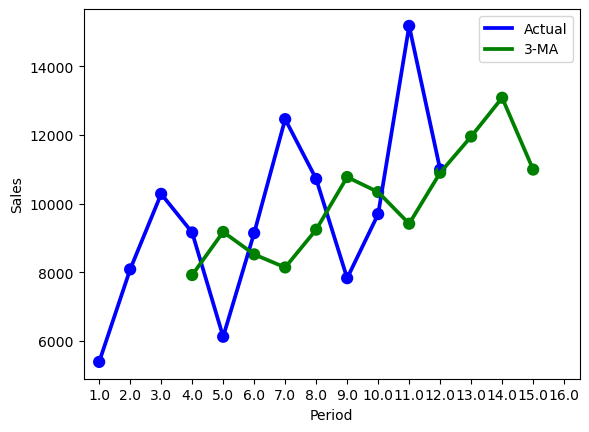

In [17]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for m in range(0,to_period):
        if m<k:
            prediction = float("NaN")
        else:
            history = df["Sales"][m-k:m]
            prediction =  history.mean()
        moving_average_df.loc[m]  = [m+1,prediction]                
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

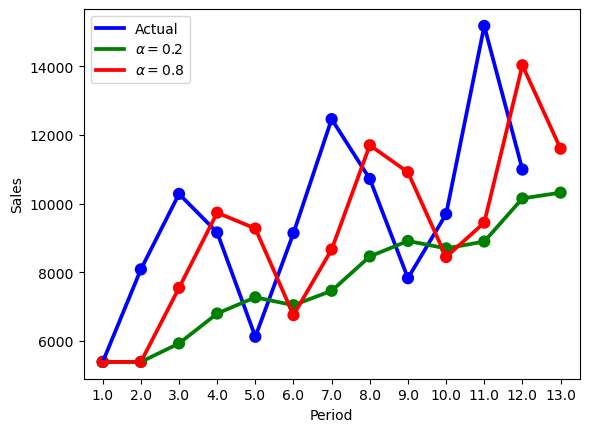

In [29]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1,df["Sales"][0]]
    num_df = len(df)
    for m in range(0,num_df):
        prediction = alpha*df['Sales'][m]+(1-alpha)*es_df['Sales'][m]
        es_df.loc[m+1]=[m+2,prediction]
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

       I   II  III
Seq               
1    100  150  200
2    120  170  220
3     90  120  180
4     80  110  150
I       97.5
II     137.5
III    187.5
dtype: float64
            I        II       III       Avg
Seq                                        
1    1.025641  1.090909  1.066667  1.061072
2    1.230769  1.236364  1.173333  1.213489
3    0.923077  0.872727  0.960000  0.918601
4    0.820513  0.800000  0.800000  0.806838
247.79882429784456


C:\Users\chuks\AppData\Local\Temp\ipykernel_26592\2663395869.py:45: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


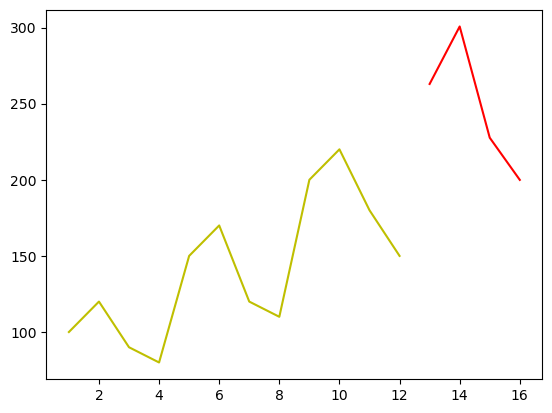

In [50]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    print(season_df)
    
    avg_df = season_df.apply(np.mean)
    print(avg_df)
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df["I"] / avg_df["I"]
    seasonal_index_df['II'] = season_df["II"] / avg_df["II"]
    seasonal_index_df['III'] = season_df["III"] / avg_df["III"]
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)
    print(seasonal_index_df)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    print(average_predict)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df["Avg"]*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

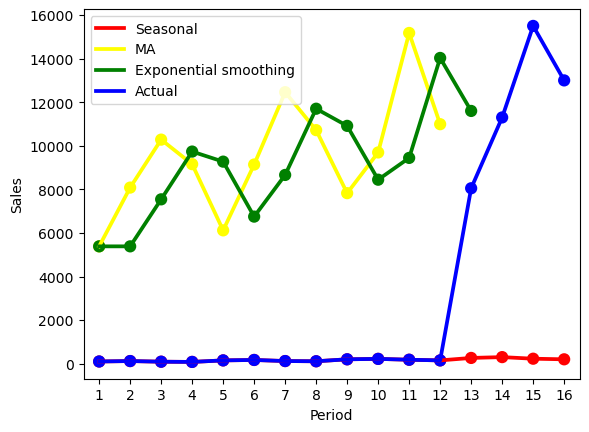

In [51]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [58]:
MAD = np.absolute(eval_df["Sales"][12:16]-moving_average(eval_df,3,16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = MAD = np.absolute(eval_df["Sales"][15]-eval_df["Sales"][14]*0.2
                 -eval_df["Sales"][13]*0.2**2
                 -eval_df["Sales"][12]*0.2**3).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = MAD = np.absolute(eval_df["Sales"][15]-eval_df["Sales"][14]*0.8
                 -eval_df["Sales"][13]*0.8**2
                 -eval_df["Sales"][12]*0.8**3).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.absolute(eval_df["Sales"][12:16]-eval_df["Sales"][0:4]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 6689.166666666666
MAD of Exponential smoothing with alpha=0.2: 9383.6
MAD of Exponential smoothing with alpha=0.8: 10753.600000000002
MAD of Seasonality Method: nan


In [67]:
MSE = (eval_df["Sales"][12:16]-moving_average(eval_df,3,16)["Sales"][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
alpha = 0.2
S = np.zeros(len(eval_df))
S[0] = eval_df["Sales"][0]
for i in range(1, len(eval_df)):
    S[i] = alpha * eval_df["Sales"][i] + (1-alpha) * S[i-1]
MSE = ((eval_df["Sales"][15] - S[14])**2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
alpha = 0.8
S = np.zeros(len(eval_df))
S[0] = eval_df["Sales"][0]
for i in range(1, len(eval_df)):
    S[i] = alpha * eval_df["Sales"][i] + (1-alpha) * S[i-1]
MSE = ((eval_df["Sales"][15] - S[14])**2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = MSE = ((eval_df["Sales"][12:16] - eval_df["Sales"][0:4].mean())**2).mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 54290358.33333333
MSE of Exponential smoothing with alpha=0.2: 48746048.24304083
MSE of Exponential smoothing with alpha=0.8: 2151673.6119465423
MSE of Seasonality Method: 148112443.75
